In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE
from tensorflow.keras.callbacks import EarlyStopping

#---Import moduls from stock-prediction package
from stock_prediction.data_prep import Data_Prep
from stock_prediction.features_exo import exo_selection

import statsmodels.formula.api as smapi

# Test 1: LSTM
learning rate, momentum

## Data exploration

In [2]:
def load_preproc_data(company='vinci'):
    """This function allows to load the data for chosen company,
    to select features make changes directly inside this function."""
    #---(1) Instantiate the Class 
    prep_class = Data_Prep(company, 252)



    #---(2) Load the first dataframe ready to use if no more modification
    df = prep_class.data_prep()



    #---(3) Function that allows us to delete some of the features we don't want to use for modelling 
    # Log Return is to False by default
    # *******************
    # if period < 252 , don't use Annual_vol
    #********************
    prep_class.select_features(df, Return = True, Log_Return=False, High_Low=False, High_Close=True, Low_Close=True,
                            Volume_Change=True, Period_Volum=True, Annual_Vol=True,
                            Period_Vol=True, Return_Index=True, Volum_Index=True, Relative_Return=True)

    #---(4) Function that add the exogenous features that you need to select 
    # returns the dataframe ready to modelling 
    # and the list of the columns to rebase it later - no VIX because no rebase for VIX - kept unchanged 
    df = exo_selection(df, sp500=True, gold=True, eurusd=False, nasdaq=False, crude=False, vix=True)

    #---(5) Sort values to make sure they are ordered *in case and drop data column
    df = df.sort_values('Date')
    df = df.drop(columns='Date')

    #---Company code on stock market
    idx = df.columns[0][7:]
    
    return df, idx

In [3]:
data, idx = load_preproc_data('vinci')

In [4]:
data.head()

,Return_DG.PA,High-Close_DG.PA,Low-Close_DG.PA,Volume-Change_DG.PA,Period_Volum_DG.PA,Annual_Vol_DG.PA,Period_Vol_DG.PA,Return_stoxx_50,Period_Volum_stoxx_50,DG.PA_relatif,Return_S&P500,Return_Gold,Vix_No_Rebase
0,0.015547,0.007076,0.015150,0.963615,0.331698,0.202937,0.202937,-0.001862,0.000000,0.017409,-0.007514,0.007844,0.1041
1,-0.002187,0.009799,0.002456,-0.407210,-0.209472,0.202602,0.202602,0.003497,0.000000,-0.005684,-0.003694,-0.003931,0.0989
2,0.006833,0.002689,0.006314,-0.156808,-0.332583,0.202592,0.202592,0.006953,-0.186563,-0.000119,0.001219,0.007735,0.0975
3,-0.003713,0.005913,0.003224,-0.368494,-0.577419,0.201847,0.201847,0.000000,0.000000,-0.003713,0.002787,0.001958,0.1007
4,-0.013239,0.008727,0.001043,0.957079,-0.171234,0.201653,0.201653,-0.010479,-0.215993,-0.002760,-0.001566,0.011803,0.1045


In [5]:
data.shape

(1027, 13)

In [ ]:
m1 = smapi.OLS.from_formula('Production ~ Rigs.shift(20)', data).fit()

df['Forecast'] = m1.fittedvalues

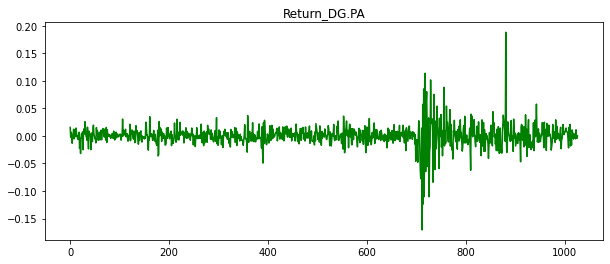

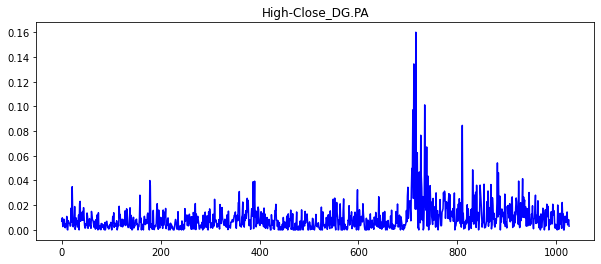

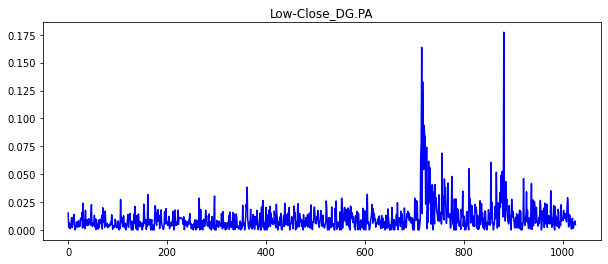

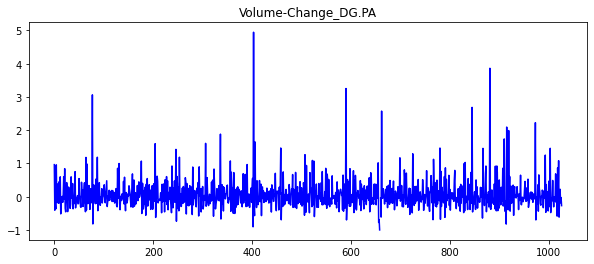

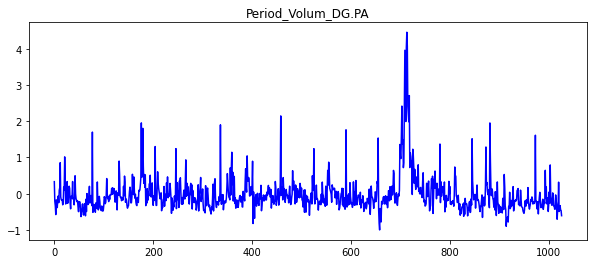

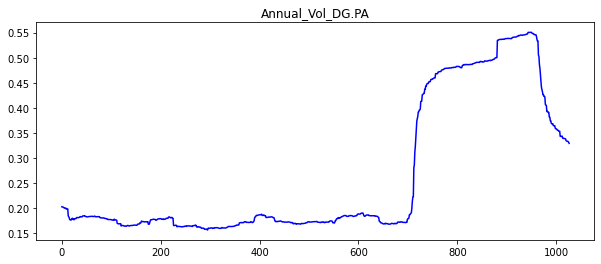

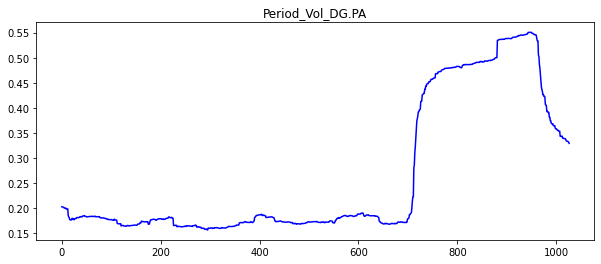

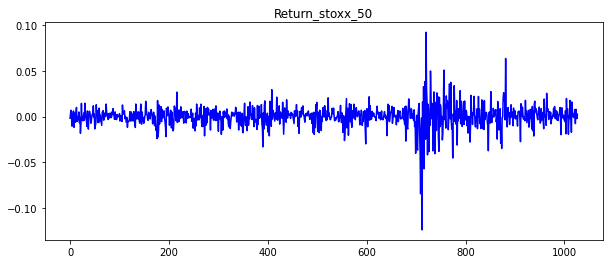

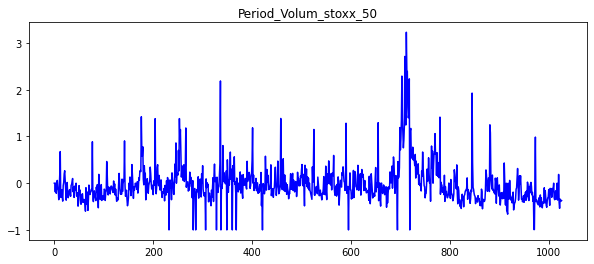

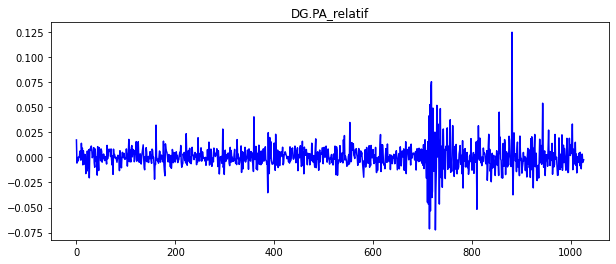

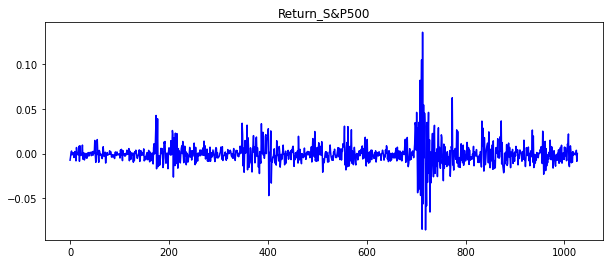

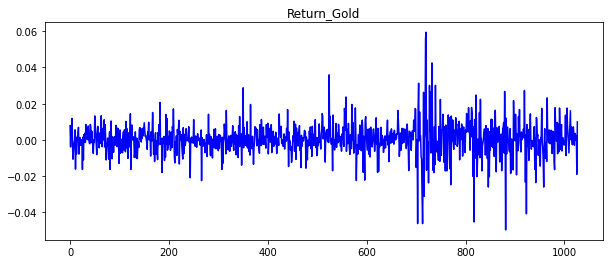

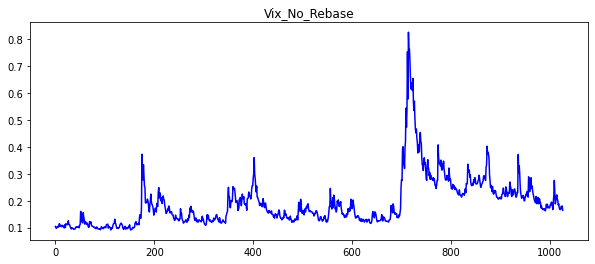

In [6]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data.columns:
    color="green" if col == f"Return_{idx}" else "blue"
    data[col].plot(figsize=(10,4), color=color)
    plt.title(col)

    plt.show()

## Data preprocessing TS oriented

In [7]:
# To avoid data leakage we have to split sets chronologically.

def train_test_val_split(df, horizon=1, train_threshold=0.6, val_threshold=0.8):
    
    # here gap=0, if we take a longer horizon it'll matter
    gap = horizon - 1

    # set a train: 60%, test: 20%, val: 20% sizes
    train = int( train_threshold*df.shape[0])
    val = int(val_threshold*df.shape[0])


    df_train = df[:train]
    df_val = df[train:val]
    df_test = df[val+gap:] # gap can matter later
    
    return df_train, df_val, df_test

In [8]:
np.random.seed(0)

In [9]:
def subsample_sequence(df, length=10, horizon=1): #, target = 'DG.PA'
    
    """This function is able to get a subsequence X and a corresponding target y
    N days after the last observationexpressed in horizon variable."""
    
    last_possible = df.shape[0] - length - horizon
    
    # fix the sequence
    
    np.random.seed(0)
    
    random_start = np.random.randint(0, last_possible) #raandom seed  = 0
    
    X = df[random_start: random_start+length].values # drop(columns=[f'Return_{target}']).
    
    # target: Close price to predict
    y = df.iloc[random_start+length+horizon][f'Return_{idx}'] # [f'Return_{target}']; taregt = 'Return'

    return X, y

In [10]:
def get_X_y(df, length=10, horizon=1, number_of_sequences=100):
    
    """This function returns a given number of X and y sequences of given length."""
    
    X, y = [], []

    for _ in range(int(number_of_sequences)):
        
        xi, yi = subsample_sequence(df, length, horizon)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Model RNN

In [11]:
#---Pipeline
def train_model(df,
                train_threshold=0.6,
                val_threshold=0.8,
                nb_sequences = 100,
                len_ = 20,
                l_rate = 0.001,
                momentum = 0.9,
                loss = 'MAPE',
                metric = MAPE,
                patience = 30,
                batch_size = 32,
                horizon=1,
                plot_history=False):
    
    """Train model function:
    Allows to split sequences and gets X and y for train, val, test sets;
    Initializes stacked RNN model with Normalization, LSTM and 2 fully connected layers.
    Returns: X_train, y_train, X_test, y_test, model"""
    

    #---Split train, test, val sets
    df_train, df_val, df_test = train_test_val_split(df, train_threshold=train_threshold, val_threshold=val_threshold)
    
    #---Get train, test, val X and y sequences
    X_train, y_train = get_X_y(df_train, length=len_, number_of_sequences=nb_sequences)
    X_val, y_val = get_X_y(df_val, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)
    X_test, y_test = get_X_y(df_test, length=len_, number_of_sequences=nb_sequences) #round(nb_sequences*0.2)
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    #---Initialize the model
    model = Sequential()
    model.add(normalizer)
    model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
    model.add(layers.GRU(30, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
#     model.add(layers.GRU(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    
    model.compile(loss=loss, 
                  optimizer=RMSprop(learning_rate=l_rate, momentum=momentum), 
                  metrics=[metric])


    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=batch_size,
            callbacks=[es],
            verbose=0)

    
    if plot_history:
        
        plot_loss(history, patience)
        
#     res = model.evaluate(X_test, y_test, verbose=0)
#     return res[1]
    return X_train, y_train, X_test, y_test, model

In [12]:
#---Plot train val losses function

def plot_loss(history, patience):
    plt.plot(history.history['loss']) # plot train loss
    plt.plot(history.history['val_loss']) # plot val loss
    plt.title('Loss & Metric')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
#     plt.plot(history.history['mean_absolute_percentage_error'])
#     plt.plot(history.history['val_mean_absolute_percentage_error'])
#     plt.title('MAPE')
#     plt.ylabel('Mean Absolute Percentage Error')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='best')
#     plt.show()
    
    stop_epoch = max(history.epoch)-patience
    val_mape = history.history['val_mean_absolute_percentage_error'][stop_epoch]

    print(f"early stopping at {max(history.epoch)} epoch.\nval_mape: {val_mape}")

In [13]:
#---load the data with selected features

data, idx = load_preproc_data('vinci')

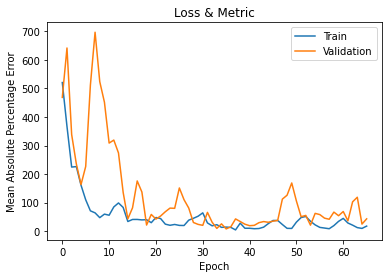

early stopping at 65 epoch.
val_mape: 7.387998104095459


In [14]:
#---train the model
X_train, y_train, X_test, y_test, model = train_model(df = data, plot_history=True)

**Val_mape is anormally huge. Need to change training period to find out why ?**

In [15]:
X_test.shape

(100, 20, 13)

In [16]:
#---Prediction
res = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

In [17]:
y_pred.shape

(100, 20, 1)

Prediction of stock return on J+1: [[-0.01751715]
 [-0.02288671]
 [-0.02474014]
 [-0.02388177]
 [-0.02278624]
 [-0.02187548]
 [-0.02163864]
 [-0.02152297]
 [-0.02074571]
 [-0.02079596]
 [-0.01922735]
 [-0.01968248]
 [-0.01903472]
 [-0.02021591]
 [-0.02189188]
 [-0.0240973 ]
 [-0.02426188]
 [-0.0238114 ]
 [-0.02340235]
 [-0.02509254]] with mape 34.838470458984375


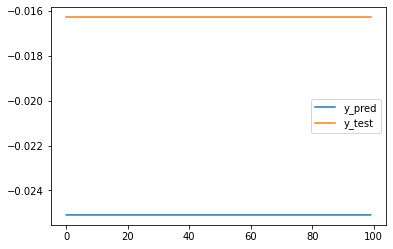

In [18]:
plt.plot(y_pred[:,-1,:], label='y_pred') #'.'
plt.plot(y_test,  label='y_test')
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred[-1]} with mape {res[1]}")

**y pred_ doesn't vary much, it seems as our model wasn't not trained well !**

**Baseline**

In [19]:
#TODO
# y_pred = last seen value
# bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

# print(f'Benchmark MAPE on the test set : {bench_res:.2f} %')

In [20]:
#df_test
df_train, df_val, df_test = train_test_val_split(data) #train_threshold=0.6, val_threshold=0.8 to test !

# X_test & y_test
X_test, y_test = get_X_y(df_test, length=20)

In [21]:
# We predict the last stock return value!
nb_sequences = 100
# y_pred_baseline = np.zeros(nb_sequences)
y_pred_baseline = 0
# bench_res = np.mean(np.abs((y_pred_baseline - y_test)/y_test))*100
bench_res = np.mean(np.abs((y_pred_baseline - np.mean(y_test)/np.mean(y_test)))*100)

print(f"Benchmark MAPE on the test set : {bench_res:.2f} %")

Benchmark MAPE on the test set : 100.00 %


In [22]:
(y_pred_baseline - y_test)

array([0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628276,
       0.01628276, 0.01628276, 0.01628276, 0.01628276, 0.01628

## (Train+val) = 90%, test = 10%

In [23]:
data, idx = load_preproc_data()

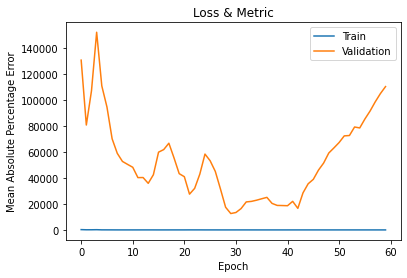

early stopping at 59 epoch.
val_mape: 12596.4560546875


In [24]:
X_train, y_train, X_test, y_test, model_1 = train_model(df = data, train_threshold=0.9, val_threshold=0.94, plot_history=True)

Prediction of stock return on J+1: [[ 0.03063692]
 [ 0.0325284 ]
 [ 0.03766245]
 [ 0.03490678]
 [ 0.02729816]
 [ 0.0201825 ]
 [ 0.01589416]
 [ 0.01612534]
 [ 0.00064362]
 [ 0.00016993]
 [-0.00295921]
 [ 0.0136127 ]
 [ 0.01962241]
 [ 0.02444823]
 [ 0.03000339]
 [ 0.02428021]
 [ 0.03639925]
 [ 0.055489  ]
 [ 0.06789583]
 [ 0.07458169]] with mape 663.76953125


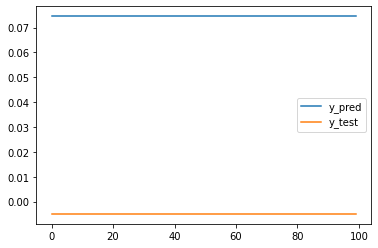

In [25]:
#---Prediction
res = model_1.evaluate(X_test, y_test, verbose=0)
y_pred = model_1.predict(X_test)
plt.plot(y_pred[:,-1,:], label='y_pred') #'.'
plt.plot(y_test,  label='y_test')
plt.legend()

print(f"Prediction of stock return on J+1: {y_pred[-1]} with mape {res[1]}")

**Can't train such a model for some reason.**

## Train our model only on first 60%/70% of data to exclude 2020-2021 pandemic effect.

In [26]:
#---Take 60% of data to train our model
data, idx = load_preproc_data()
threshold_data = int(0.6*data.shape[0])
data_60 = data[:threshold_data].copy()

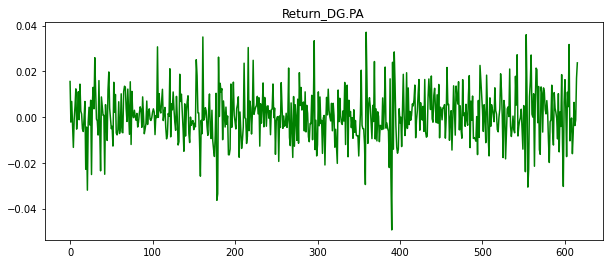

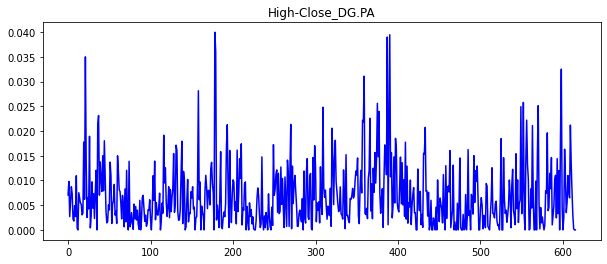

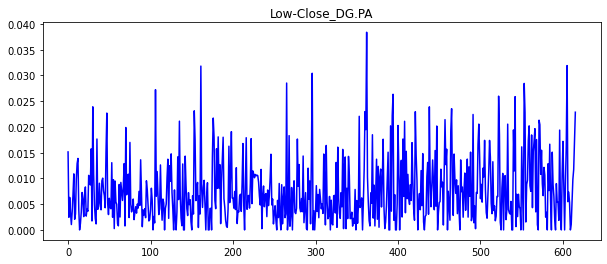

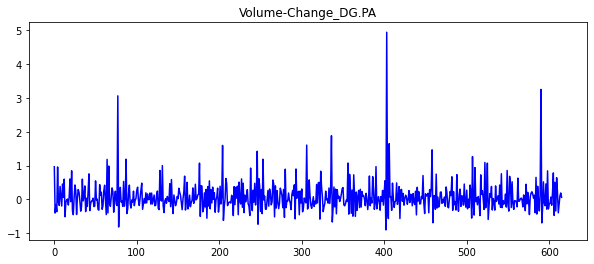

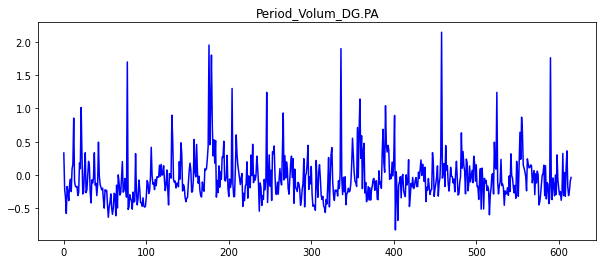

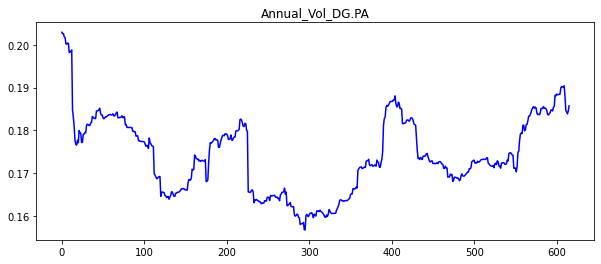

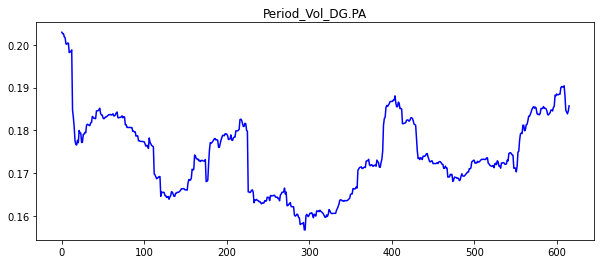

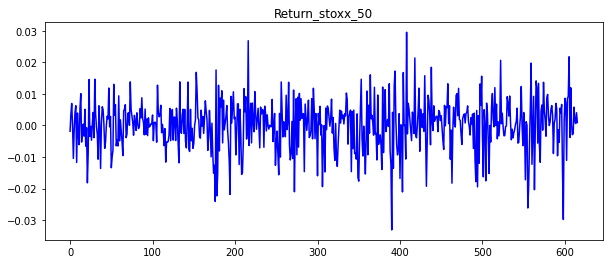

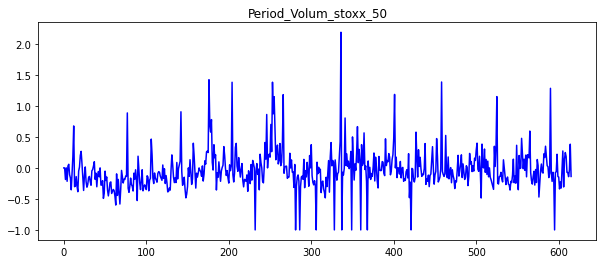

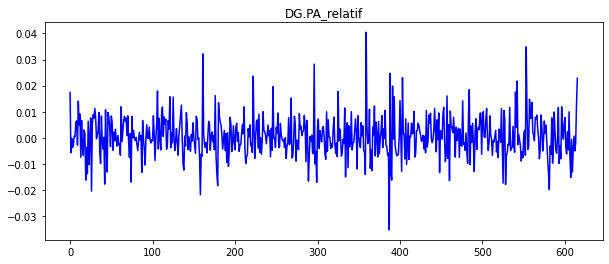

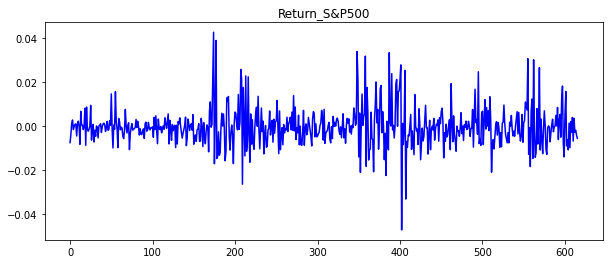

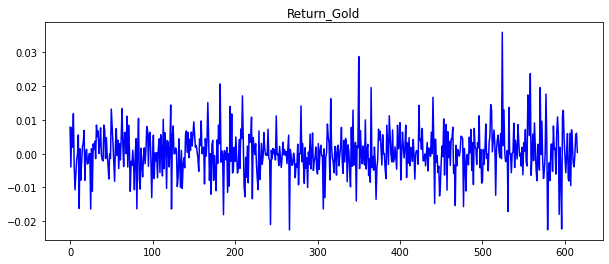

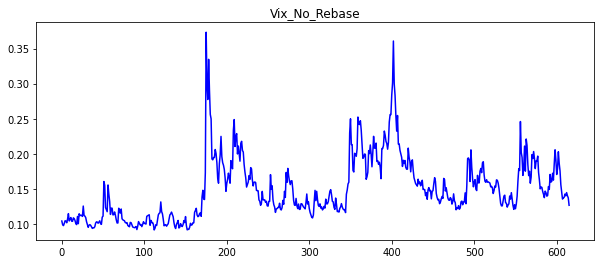

In [27]:
#---Plot the temporal progression of different features of our Data

%matplotlib inline

for col in data_60.columns:
    color="green" if col == "Return_DG.PA" else "blue"
    data_60[col].plot(figsize=(10, 4), color=color)
    plt.title(col)

    plt.show()

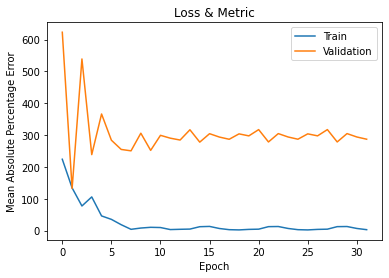

early stopping at 31 epoch.
val_mape: 132.2724609375


In [28]:
#---Train model with 60% of data
X_train, y_train, X_test, y_test, model = train_model(data_60, momentum=0.9, loss='MAPE', plot_history=True)

**60%**

In [29]:
#---Take 60% of data to train our model
data, idx = load_preproc_data()
threshold_data = int(0.6*data.shape[0])
data_60 = data[:threshold_data].copy()

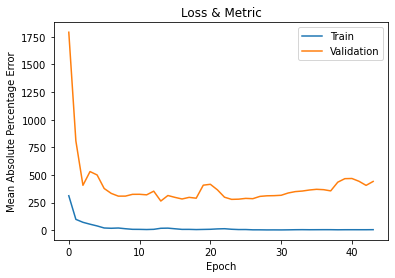

early stopping at 43 epoch.
val_mape: 263.52508544921875


In [30]:
X_train, y_train, X_test, y_test, model = train_model(data_60, plot_history=True)

**Finally MAPE is less than our benchmark 100%** => should we take this business decision and train our model on first 60% of data ?

## Test length of sequnces and number sequnces

In [31]:
#---Test 1: nb_sequences

def test_nb_sequences(df, start=50, stop=650, step=50):
    
    """This function computes MAPE in given range
    to find best nb_sequences"""
    
    nb_sequences_grid = np.arange(start, stop, step)
    MAPE = []

    for nb_sequences in nb_sequences_grid:
            X_train, y_train, X_test, y_test, model = train_model(df=df, nb_sequences=nb_sequences)
            res = model.evaluate(X_test, y_test)
            MAPE.append((nb_sequences, round(res[1])))
            print(f"For {nb_sequences} sequences the MAPE is of {res[1]:.2f} %")

In [32]:
test_nb_sequences(data_60, start=50, stop=650, step=50)

2/2 [==============================] - 0s 8ms/step - loss: 220.2741 - mean_absolute_percentage_error: 220.2741
For 50 sequences the MAPE is of 220.27 %
4/4 [==============================] - 0s 7ms/step - loss: 334.3348 - mean_absolute_percentage_error: 334.3348
For 100 sequences the MAPE is of 334.33 %
5/5 [==============================] - 0s 8ms/step - loss: 658.7934 - mean_absolute_percentage_error: 658.7934
For 150 sequences the MAPE is of 658.79 %
7/7 [==============================] - 0s 6ms/step - loss: 159.6341 - mean_absolute_percentage_error: 159.6341
For 200 sequences the MAPE is of 159.63 %
8/8 [==============================] - 0s 5ms/step - loss: 328.0083 - mean_absolute_percentage_error: 328.0083
For 250 sequences the MAPE is of 328.01 %
10/10 [==============================] - 0s 5ms/step - loss: 218.3916 - mean_absolute_percentage_error: 218.3916
For 300 sequences the MAPE is of 218.39 %
11/11 [==============================] - 0s 7ms/step - loss: 103.9883 - mean_abso

KeyboardInterrupt: 

In [ ]:
#---Test 2: length of sequence

def test_len_sequence(df, start=10, stop=30, step=5):
    
    """This function computes MAPE in given range
    to find best nb_sequences"""
    
    len_grid = np.arange(start, stop, step)
    MAPE = []

    for len_ in len_grid:
            res = train_model(df, len_=len_)
            MAPE.append((len_, round(res[1])))
            print(f"For lenght of sequence {len_} the MAPE is of {res[1]:.2f} %")

In [ ]:
#---Test nb_sequences and len_
def grid(df, start_len = 10,stop_len = 30, step_len = 5,
            start_nbs = 270, stop_nbs = 330, step_nbs=10):
    
    """This function computes MAPE in given range
    to find best nb_sequences AND the optimal lenght of sequences."""
    
    len_grid = np.arange(start_len,stop_len, step_len)
    nb_sequences_grid = np.arange(start_nbs,stop_nbs, step_nbs)
    MAPE = []

    for len in len_grid:
        for nb_sequences in nb_sequences_grid:
            res = train_model(df, nb_sequences=100)
            MAPE.append((nb_sequences, len_, res[1]))

            print(f"For {nb_sequences} sequences of lenght {len_} each, the MAPE is of {res[1]:.2f} %")